In [3]:
# !pip install geopandas

In [4]:
import os
import pandas as pd
from urllib.request import urlretrieve
from zipfile import ZipFile
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

class DataDownloader:
    def __init__(self, data_url, file_name):
        self.data_url = data_url
        self.file_name = file_name
        self.downloads_dir = os.path.join(os.getcwd(), 'downloads')
        self.zip_dir = os.path.join(self.downloads_dir, 'zip_files')

        # Check if directories exist, create if not
        for directory in [self.downloads_dir, self.zip_dir]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        # Check if file already exists
        if not os.path.isfile(os.path.join(self.downloads_dir, self.file_name)):
            self.download_data()

        # Unzip the downloaded file
        self.unzip_data()

        # Read datasets into corresponding pandas dataframes
        self.airlines_df = pd.read_csv(os.path.join(self.zip_dir, 'airlines.csv')).drop(columns=["index"], axis=1)
        self.airplanes_df = pd.read_csv(os.path.join(self.zip_dir, 'airplanes.csv')).drop(columns=["index"], axis=1)
        self.airports_df = pd.read_csv(os.path.join(self.zip_dir, 'airports.csv')).drop(
            columns=["index", "Type", "Source"], axis=1)
        self.routes_df = pd.read_csv(os.path.join(self.zip_dir, 'routes.csv')).drop(columns=["index"], axis=1)

    def download_data(self):
        file_path = os.path.join(self.downloads_dir, self.file_name)
        urlretrieve(self.data_url, file_path)
        print(f"Downloaded {self.file_name} to {self.downloads_dir}")

    def unzip_data(self):
        zip_file_path = os.path.join(self.downloads_dir, self.file_name)
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(self.zip_dir)
        print(f"Unzipped {self.file_name} to {self.zip_dir}")

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the Haversine distance between two sets of latitude and longitude coordinates.
        input:
        -param lat1: Latitude of the first point.
        -param lon1: Longitude of the first point.
        -param lat2: Latitude of the second point.
        -param lon2: Longitude of the second point.
        -return: Haversine distance in kilometers.
        """
        R = 6371  # Radius of the Earth in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c
        return distance

    def airport_distance(self, airport1="", airport2=""):
        """
        Extract the latitude and longitude for the two chosen airports to then call the haversine_distance method
        which then calculates the distance of the chosen airports.
        input:
        -param airport1
        -param airport2
        output:
        -param lat1: Latitude of the first point.
        -param lon1: Longitude of the first point.
        -param lat2: Latitude of the second point.
        -param lon2: Longitude of the second point.
        call haversine_distance(lat1, lon1, lat2, lon2) with output parameter
        """
        lat1 = float(self.airports_df[self.airports_df["Name"] == airport1].iloc[:, 6])
        lat2 = float(self.airports_df[self.airports_df["Name"] == airport2].iloc[:, 6])
        lon1 = float(self.airports_df[self.airports_df["Name"] == airport1].iloc[:, 7])
        lon2 = float(self.airports_df[self.airports_df["Name"] == airport2].iloc[:, 7])
        distance = self.haversine_distance(lat1, lon1, lat2, lon2)
        print(distance, "km")
        
    def plot_airports_map(self, country):
        """
        Plot a map with the locations of airports in the specified country.

        Parameters:
        - country (str): Name of the country.

        Returns:
        - None
        """
        country_airports = self.airports_df[self.airports_df["Country"] == country]
        if country_airports.empty:
            print("Error: Country does not exist or has no airports.")
            return
        
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        ax = world.plot(color='white', edgecolor='black', figsize=(10, 6))

        country_map = gpd.GeoDataFrame(country_airports,
                                       geometry=gpd.points_from_xy(country_airports.Longitude,
                                                                    country_airports.Latitude))
        country_map.plot(ax=ax, color='red', markersize=10)
        plt.title(f'Airports in {country}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    
    def distance_analysis(self):
        """
        Plot the distribution of flight distances for all flights.
        """
        distances = []
        for index, row in self.routes_df.iterrows():
            source_airport = row['Source airport']
            destination_airport = row['Destination airport']
            source_info = self.airports_df[self.airports_df['IATA'] == source_airport]
            destination_info = self.airports_df[self.airports_df['IATA'] == destination_airport]
            if not source_info.empty and not destination_info.empty:
                source_coords = (source_info.iloc[0]['Latitude'], source_info.iloc[0]['Longitude'])
                destination_coords = (destination_info.iloc[0]['Latitude'], destination_info.iloc[0]['Longitude'])
                distance = self.haversine_distance(*source_coords, *destination_coords)
                distances.append(distance)
        plt.hist(distances, bins=20, color='skyblue', edgecolor='black')
        plt.xlabel('Distance (km)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Flight Distances')
        plt.show()

    def plot_flights(self, airport, internal=False, fig=None, ax=None):
        """
        Plot flights leaving the specified airport.

        Parameters:
        - airport (str): IATA code of the airport.
        - internal (bool): If True, plot only flights within the same country. Default is False.
        - fig (plt.figure, optional): Existing figure object to use for the plot.
        - ax (plt.axes, optional): Existing axes object to use for the plot.

        Returns:
        - plt.figure: Figure object containing the plot.
        - plt.axes: Axes object containing the plot.
        """
        if fig is None or ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))

        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        airport_point = Point(self.airports_df[self.airports_df['IATA'] == airport]['Longitude'].iloc[0], 
                              self.airports_df[self.airports_df['IATA'] == airport]['Latitude'].iloc[0])

        if internal:
            airport_country = self.airports_df[self.airports_df['IATA'] == airport]['Country'].iloc[0]
            internal_routes = self.routes_df[(self.routes_df['Source airport'] == airport) & 
                                             (self.routes_df['Destination airport'].isin(
                                                 self.airports_df[self.airports_df['Country'] == airport_country]['IATA']
                                             ))]
            internal_routes = internal_routes.merge(self.airports_df[['IATA', 'Latitude', 'Longitude', 'Country']], 
                                                    left_on='Destination airport', right_on='IATA', how='inner')

            ax.set_title(f'Internal Flights from {airport}')
        else:
            all_routes = self.routes_df[self.routes_df['Source airport'] == airport]
            all_routes = all_routes.merge(self.airports_df[['IATA', 'Latitude', 'Longitude', 'Country']], 
                                          left_on='Destination airport', right_on='IATA', how='inner')

            ax.set_title(f'All Flights from {airport}')

        world.plot(ax=ax, color='lightgrey')
        ax.plot(airport_point.x, airport_point.y, 'ro', markersize=5, label='Airport')

        for _, route in internal_routes.iterrows() if internal else all_routes.iterrows():
            route_line = LineString([(airport_point.x, airport_point.y), (route['Longitude'], route['Latitude'])])
            ax.plot(*route_line.xy, 'b-')

        ax.legend()
        return fig, ax
    
    def plot_top_airplane_models(self, countries=None, n=5):
        """
        Plot the N most used airplane models by number of routes.
        If countries are specified, plot only for those countries.
        If countries is None, plot for all dataset.
        :param countries: List of country names or None.
        :param n: Number of top airplane models to plot.
        """
        # Filter routes by countries if specified
        if countries:
            filtered_routes = self.routes_df[
                (self.routes_df['Source airport'].isin(self.airports_df[self.airports_df['Country'].isin(countries)]['IATA'])) &
                (self.routes_df['Destination airport'].isin(self.airports_df[self.airports_df['Country'].isin(countries)]['IATA']))
            ]
        else:
            filtered_routes = self.routes_df

        # Get the count of routes for each airplane model
        airplane_model_counts = filtered_routes['Equipment'].value_counts().head(n)

        # Plot the top N airplane models
        fig, ax = plt.subplots()
        airplane_model_counts.plot(kind='bar', ax=ax)
        ax.set_xlabel('Airplane Model')
        ax.set_ylabel('Number of Routes')
        ax.set_title('Top {} Airplane Models by Number of Routes'.format(n))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_country_flights(self, country, internal=False):
        """
        Plot flights leaving or arriving in the specified country.
        :param country: Name of the country.
        :param internal: If True, plot only internal flights; otherwise, plot all flights.
        """
        if internal:
            filtered_routes = self.routes_df[
                (self.routes_df['Source airport'].isin(self.airports_df[self.airports_df['Country'] == country]['IATA'])) &
                (self.routes_df['Destination airport'].isin(self.airports_df[self.airports_df['Country'] == country]['IATA']))
            ]
        else:
            filtered_routes = self.routes_df[
                (self.routes_df['Source airport'].isin(self.airports_df[self.airports_df['Country'] == country]['IATA'])) |
                (self.routes_df['Destination airport'].isin(self.airports_df[self.airports_df['Country'] == country]['IATA']))
            ]

        # Get airport coordinates
        airport_coords = self.airports_df[self.airports_df['Country'] == country][['Longitude', 'Latitude']].values

        # Plot the flights on a map
        fig, ax = plt.subplots(figsize=(10, 8))
        for index, row in filtered_routes.iterrows():
            source = self.airports_df[self.airports_df['IATA'] == row['Source airport']].iloc[0]
            dest = self.airports_df[self.airports_df['IATA'] == row['Destination airport']].iloc[0]
            ax.plot([source['Longitude'], dest['Longitude']], [source['Latitude'], dest['Latitude']], color='blue')
        ax.scatter(airport_coords[:, 0], airport_coords[:, 1], color='red', label='Airports')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Flights in {}'.format(country))
        ax.legend()
        plt.show()


# Example usage
data_url = "https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false"
file_name = "data.zip"
data_downloader = DataDownloader(data_url, file_name)

# Manual Unit test with correct distances out of this source ("https://www.luftlinie.org/9.652170181274414,%206.462259769439697/5-1-%E0%B8%AB%E0%B8%A1%E0%B8%B9%E0%B9%88-5-%E0%B8%95%E0%B8%B3%E0%B8%9A%E0%B8%A5%E0%B8%81%E0%B8%81%E0%B8%9B%E0%B8%A5%E0%B8%B2%E0%B8%8B%E0%B8%B4%E0%B8%A7-%E0%B8%AD%E0%B8%B3%E0%B9%80%E0%B8%A0%E0%B8%AD%E0%B8%A0%E0%B8%B9%E0%B8%9E%E0%B8%B2%E0%B8%99-%%E0%B8%88%E0%B8%B1%E0%B8%87%E0%B8%AB%E0%B8%A7%E0%B8%B1%E0%B8%94%E0%B8%AA%E0%B8%81%E0%B8%A5%E0%B8%99%E0%B8%84%E0%B8%A3-47180"):
"""
Unit test: comparing 3 long distances out of the model with the real distance taken out of the given source above:
first call function airport_distance
second put in two airport names 
third compare results with real distance calculated with source above
forth repeat three more times
finally evaluate how close the model's predictions are to the real distances
"""
print("Unit test: comparing model performance with real-world distances \n")
print("The model predicts:")
data_downloader.airport_distance("Kugaaruk Airport", "Húsavík Airport")
print("the real distance is 2,945.76 km")

print("\n The model predicts:")
data_downloader.airport_distance("Húsavík Airport", "Minna Airport")
print("the real distance is 6,519.29 km")

print("\n The model predicts:")
data_downloader.airport_distance("Minna Airport", "Kleine Brogel Air Base")
print("the real distance is 4,617.28 km")

print("\n Even over long distances, the model gives us accurate distances")

Unzipped data.zip to C:\Users\мси\Downloads\portfolio\group_19\downloads\zip_files
Unit test: comparing model performance with real-world distances 

The model predicts:
2945.754511637728 km
the real distance is 2,945.76 km

 The model predicts:
6520.3538796109415 km
the real distance is 6,519.29 km

 The model predicts:
4617.274033404375 km
the real distance is 4,617.28 km

 Even over long distances, the model gives us accurate distances


C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


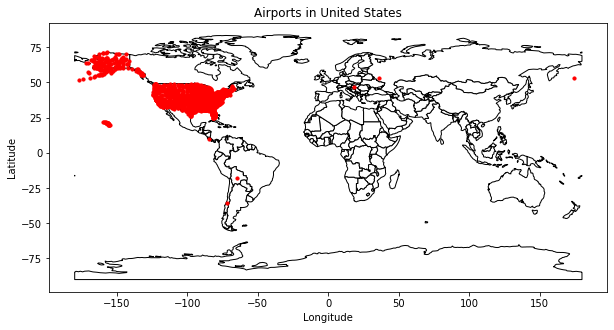

In [5]:
# Plot airports map for a specific country
data_downloader.plot_airports_map("United States")

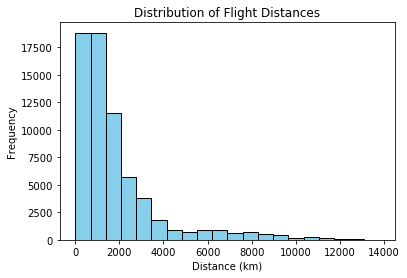

In [2]:
# Call distance_analysis method
data_downloader.distance_analysis()


C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x277810c3408>)

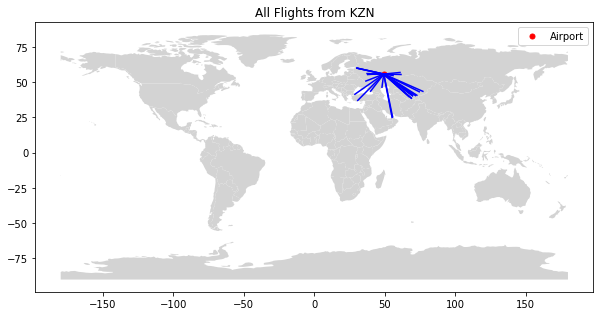

In [22]:
# Call plot_flights method to plot all flights leaving a specific airport
airport_iata = "KZN"  # Example airport IATA code
data_downloader.plot_flights(airport_iata)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27781860a48>)

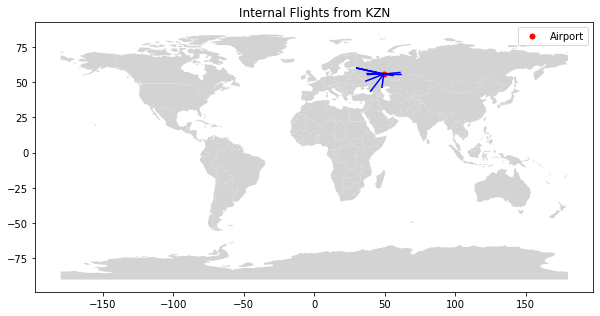

In [23]:
# Call plot_flights method with internal=True to plot internal flights leaving a specific airport
data_downloader.plot_flights(airport_iata, internal=True)

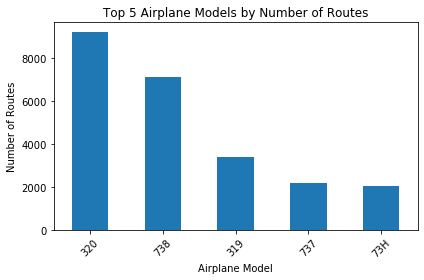

In [2]:
# Plot the top 5 airplane models for all dataset
data_downloader.plot_top_airplane_models()

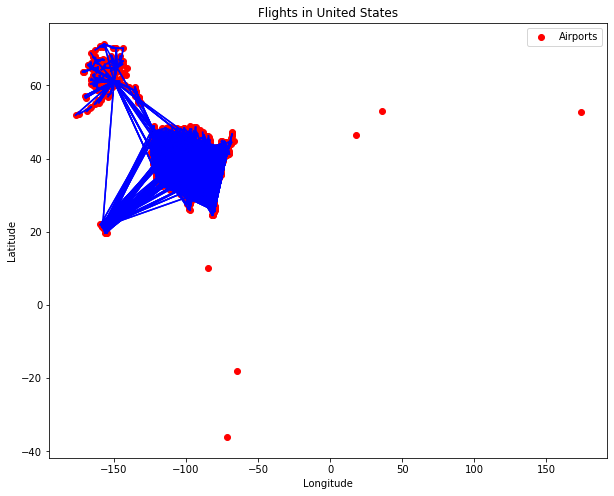

In [5]:
# Plot flights leaving or arriving in a specific country (e.g., USA) with internal flights
data_downloader.plot_country_flights('United States', internal=True)